**Installing kaggle plugin**

In [8]:
!pip install kaggle

**Connecting our project with google drive**

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Creating a directory to store in the kaggle api key**

In [10]:
! mkdir ~/.kaggle

**Importing our kaggle API key to this project**

In [11]:
!cp /content/drive/MyDrive/College/kaggle.json ~/.kaggle/kaggle.json

**Changing permission to the kaggle api to Read & Write**

In [12]:
! chmod 600 ~/.kaggle/kaggle.json

**Downloading Dataset**



In [13]:
! kaggle datasets download drgfreeman/rockpaperscissors

Dataset URL: https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors
License(s): CC-BY-SA-4.0
100% 305M/306M [00:14<00:00, 26.8MB/s]
100% 306M/306M [00:14<00:00, 22.8MB/s]


**Importing libraries**

In [14]:
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from keras.preprocessing import image
from google.colab import files
import keras
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.utils import to_categorical

**Extracting the dataset into a folder called rockpaperscissors**

In [17]:
local_zip = '/content/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r') #read the zipfile
zip_ref.extractall('/tmp') #extract all cotents of the zipfile in the tmp directory
zip_ref.close()
base_dir = '/tmp/rockpaperscissors'
train_dir = os.path.join(base_dir, 'rps-cv-images')

In [18]:
print(os.listdir(base_dir))

['rock', 'scissors', 'paper', 'README_rpc-cv-images.txt', 'rps-cv-images']


In [19]:
os.listdir('/tmp/rockpaperscissors/rps-cv-images')

['rock', 'scissors', 'paper', 'README_rpc-cv-images.txt']

**Preparing data for the model**

In [20]:
train_datagen = ImageDataGenerator(
                rescale=1./255, #resale from 0-255 RGB range to 0-1 range
                rotation_range=20, #rotate image in 0-20 degrees
                horizontal_flip=True, #rotate image horizontally
                shear_range = 0.2, #shear angle by 0.2 degree range in counter clockwise
                fill_mode = 'nearest', #fill newly created pixels
                validation_split=0.4) #split dataset images by 40% for validation step

validation_datagen = ImageDataGenerator(rescale = 1.0/255, validation_split=0.4)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(100,150), #all images will resized to 100x150px
        batch_size=32,
        class_mode='categorical', #determines the type of label array, we use categorical due to having 3 classes "rock,paper,scissors"
        subset='training') #subsets the data into traing by the value of validation split

validation_generator = validation_datagen.flow_from_directory(
        train_dir,
        target_size=(100,150),
        batch_size=32,
        class_mode='categorical',
        subset='validation') #subsets the data into validation by the value of validation split

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


**CNN Architecture**

In [21]:
model = Sequential()

model.add(Conv2D(64, (3,3), input_shape=(100, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(16, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(3))
model.add(Activation('softmax'))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 148, 64)       1792      
                                                                 
 activation (Activation)     (None, 98, 148, 64)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 74, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 72, 16)        9232      
                                                                 
 activation_1 (Activation)   (None, 47, 72, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 36, 16)        0         
 g2D)                                                   

Flatten layer = 5440 -> last max pooling is 10*17*32 <br>
Dense 1st layer 64 neuron used, 64*5440+64 = 348224 <br>
Dense 2nd layer 3 image categories with total 3*64+3 = 195

**Compile pre-built model**

In [23]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy', keras.metrics.AUC()])

**Early stopping when model reaches the accuracy threshold to reduce model overfitting**

In [24]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.000003)

**Training model**

In [25]:
history = model.fit(
    train_generator, #train using the training dataset
    epochs=10, #10 iterations
    validation_data=validation_generator, #evaluates the model using validation dataset
    callbacks=[learning_rate_reduction]) #will stop when the maximum accuracy meets the threshold

Epoch 1/10
42/42 [==============================] - 64s 1s/step - loss: 0.8997 - accuracy: 0.5487 - auc: 0.7564 - val_loss: 0.4704 - val_accuracy: 0.8398 - val_auc: 0.9453 - lr: 0.0010
Epoch 2/10
42/42 [==============================] - 62s 1s/step - loss: 0.3875 - accuracy: 0.8516 - auc: 0.9601 - val_loss: 0.3418 - val_accuracy: 0.8787 - val_auc: 0.9652 - lr: 0.0010
Epoch 3/10
42/42 [==============================] - 56s 1s/step - loss: 0.2490 - accuracy: 0.9018 - auc: 0.9823 - val_loss: 0.2096 - val_accuracy: 0.9359 - val_auc: 0.9853 - lr: 0.0010
Epoch 4/10
42/42 [==============================] - 68s 2s/step - loss: 0.2386 - accuracy: 0.9186 - auc: 0.9828 - val_loss: 0.1831 - val_accuracy: 0.9462 - val_auc: 0.9898 - lr: 0.0010
Epoch 5/10
42/42 [==============================] - 61s 1s/step - loss: 0.1551 - accuracy: 0.9422 - auc: 0.9927 - val_loss: 0.2125 - val_accuracy: 0.9348 - val_auc: 0.9871 - lr: 0.0010
Epoch 6/10
42/42 [==============================] - 53s 1s/step - loss: 0.1

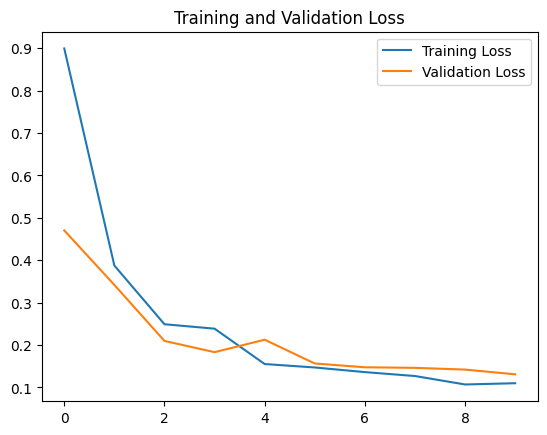

In [26]:
plt.plot(history.history['loss'],label="Training Loss")
plt.plot(history.history['val_loss'],label="Validation Loss")
plt.title('Training and Validation Loss')
plt.legend()

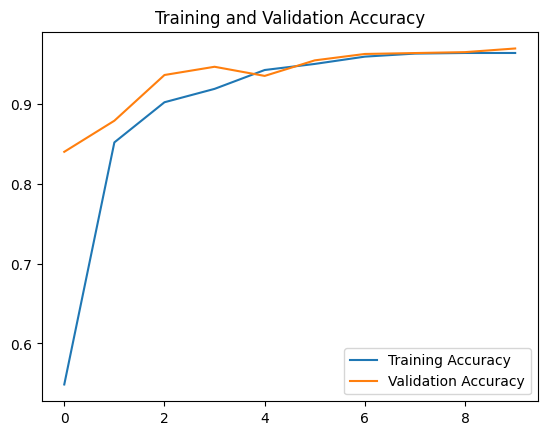

In [27]:
plt.plot(history.history['accuracy'],label="Training Accuracy")
plt.plot(history.history['val_accuracy'],label="Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.legend()

In [28]:
def evaluate(model):

  validation_generator = train_datagen.flow_from_directory(
          train_dir,
          target_size=(100,150),
          batch_size=32,
          class_mode='categorical',
          shuffle = False,
          subset='validation')

  batch_size = 32
  num_of_test_samples = len(validation_generator.filenames)

  Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
  y_pred = np.argmax(Y_pred, axis=1)

  print('\nConfusion Matrix\n')
  print(confusion_matrix(validation_generator.classes, y_pred))


  print('\n\nClassification Report\n')
  target_names = ['Rock', 'Paper', 'Scissors']
  print(classification_report(validation_generator.classes, y_pred, target_names=target_names))


In [29]:
evaluate(model)

Found 874 images belonging to 3 classes.


<ipython-input-28-0cea1ab906f2>:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)



Confusion Matrix

[[270  10   4]
 [  5 285   0]
 [  7   1 292]]


Classification Report

              precision    recall  f1-score   support

        Rock       0.96      0.95      0.95       284
       Paper       0.96      0.98      0.97       290
    Scissors       0.99      0.97      0.98       300

    accuracy                           0.97       874
   macro avg       0.97      0.97      0.97       874
weighted avg       0.97      0.97      0.97       874



Saving 1MOm36DHK0R8OfIC.png to 1MOm36DHK0R8OfIC (1).png
1/1 [==============================] - 0s 26ms/step
1MOm36DHK0R8OfIC (1).png
rock


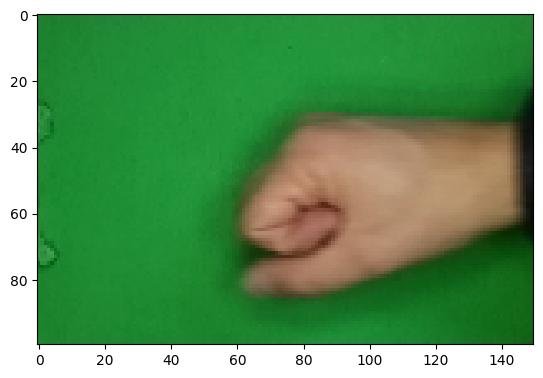

In [41]:
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
  # predict images
  path = fn
  img_source = image.load_img(path, target_size = (100, 150))
  imgplot = plt.imshow(img_source)
  x = image.img_to_array(img_source)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 10)

  print(fn)
  if classes[0, 0] == 1:
    print('paper')
  elif classes[0, 1] == 1:
    print('rock')
  elif classes[0, 2] == 1:
    print('scissors')